# Import Libraries

In [709]:
# library imports
import sklearn
import matplotlib
import numpy as np
%matplotlib inline
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from IPython import InteractiveShell
from xgboost import plot_importance
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

In [710]:
# configurations for pretty display
InteractiveShell.ast_node_interactivity="all"
pd.set_option('max_colwidth',-1)
pd.set_option('max_columns',None)

# Load Data

In [627]:
# load data
df=pd.read_csv('Data/train.csv')
df.head()
len(df)

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


116058

# Treat Class Imbalance for Exploratory Data Analysis (EDA)

In [628]:
# drop loan_id column
df.drop(columns=['loan_id'],axis=1,inplace=True)
# rename the target
df.rename(columns={'m13':'delinquency'},inplace=True)
df.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'delinquency'],
      dtype='object')

In [629]:
# distribution of delinquency in the data
round(df.delinquency.value_counts(normalize=True),2)
print("\033[1mHuge imbalance")

0    0.99
1    0.01
Name: delinquency, dtype: float64

Huge imbalance


## Random Oversampling

In [630]:
df=df.sample(frac=1,random_state=33) # shuffle data
df_1_over= df[df.delinquency==1].sample(len(df[df.delinquency==0]),replace=True) # sample minority class with replacement
df_s=pd.concat([df[df.delinquency==0],df_1_over])
df_s=df_s.reset_index(drop=True)
round(df_s.delinquency.value_counts(normalize=True),2)
df_s.head(2)

1    0.5
0    0.5
Name: delinquency, dtype: float64

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency
0,Y,Edwards-Hoffman,3.750,345000,240,2012-02-01,04/2012,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,X,OTHER,3.375,116000,180,2012-01-01,03/2012,51,2.0,31.0,758.0,B12,0.0,755.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Treat Missing Values

In [631]:
# check percentage of missing values
round(df_s.isnull().mean(),3)*100
print("\033[1mNo missing values")

source                      0.0
financial_institution       0.0
interest_rate               0.0
unpaid_principal_bal        0.0
loan_term                   0.0
origination_date            0.0
first_payment_date          0.0
loan_to_value               0.0
number_of_borrowers         0.0
debt_to_income_ratio        0.0
borrower_credit_score       0.0
loan_purpose                0.0
insurance_percent           0.0
co-borrower_credit_score    0.0
insurance_type              0.0
m1                          0.0
m2                          0.0
m3                          0.0
m4                          0.0
m5                          0.0
m6                          0.0
m7                          0.0
m8                          0.0
m9                          0.0
m10                         0.0
m11                         0.0
m12                         0.0
delinquency                 0.0
dtype: float64

No missing values


# EDA

## source

In [632]:
# distribution of source
round(df_s.source.value_counts(normalize=True)*100,2)

X    51.65
Y    35.48
Z    12.87
Name: source, dtype: float64

In [633]:
# source vs delinquency
df_s.groupby('source')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\033[1mDelinquency is same across sources, doesnt have much variance')

source
X    0.467
Y    0.545
Z    0.510
Name: delinquency, dtype: float64

Delinquency is same across sources, doesnt have much variance


## financial institution

In [634]:
# distribution of financial institution
round(df_s.financial_institution.value_counts(normalize=True)*100,2)

OTHER                          42.68
Browning-Hart                  27.49
Swanson, Newton and Miller     6.57 
Edwards-Hoffman                5.28 
Martinez, Duffy and Bird       3.80 
Miller, Mcclure and Allen      2.84 
Turner, Baldwin and Rhodes     1.88 
Nicholson Group                1.78 
Cole, Brooks and Vincent       1.64 
Suarez Inc                     1.16 
Richards-Walters               1.03 
Taylor, Hunt and Rodriguez     0.86 
Sanchez-Robinson               0.59 
Sanchez, Hays and Wilkerson    0.52 
Thornton-Davis                 0.50 
Romero, Woods and Johnson      0.48 
Anderson-Taylor                0.44 
Richardson Ltd                 0.29 
Chapman-Mcmahon                0.17 
Name: financial_institution, dtype: float64

In [635]:
# financial institution vs delinquency
df_s.groupby('financial_institution')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\033[1mDelinquency is same across financial institutions, doesnt have much variance')

financial_institution
Anderson-Taylor                0.527
Browning-Hart                  0.501
Chapman-Mcmahon                0.000
Cole, Brooks and Vincent       0.568
Edwards-Hoffman                0.605
Martinez, Duffy and Bird       0.465
Miller, Mcclure and Allen      0.521
Nicholson Group                0.489
OTHER                          0.498
Richards-Walters               0.390
Richardson Ltd                 0.285
Romero, Woods and Johnson      0.321
Sanchez, Hays and Wilkerson    0.294
Sanchez-Robinson               0.120
Suarez Inc                     0.334
Swanson, Newton and Miller     0.550
Taylor, Hunt and Rodriguez     0.371
Thornton-Davis                 0.440
Turner, Baldwin and Rhodes     0.577
Name: delinquency, dtype: float64

Delinquency is same across financial institutions, doesnt have much variance


## interest_rate

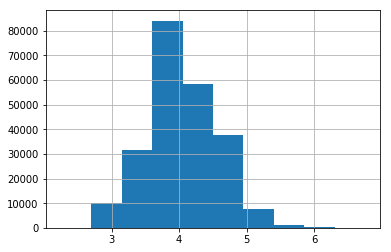

In [636]:
# distribution of interest rate
df_s.interest_rate.hist();

In [637]:
# max and min interest rates
df_s.interest_rate.max()
df_s.interest_rate.min()

6.75

2.25

interest rate and delinquency are positively correlated.


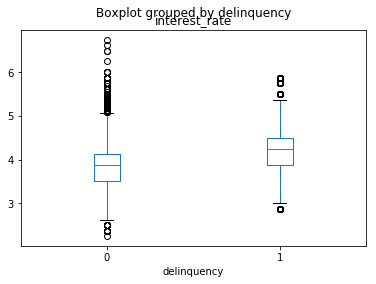

In [638]:
# interest_rate vs delinquency
df_s.boxplot(column='interest_rate',by='delinquency',grid=False)
print('\033[1minterest rate and delinquency are positively correlated.');

## unpaid_principal_bal

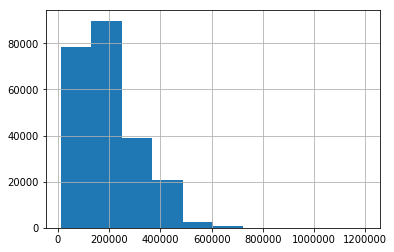

In [639]:
# distribution of unpaid_principal_bal
df_s.unpaid_principal_bal.hist();

In [640]:
# max and min unpaid principal balance
df_s.unpaid_principal_bal.max()
df_s.unpaid_principal_bal.min()

1200000

11000

Not much difference


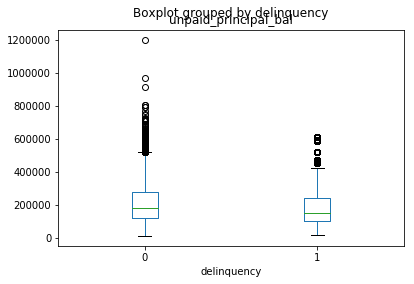

In [641]:
# unpaid_principal_bal vs delinquency
df_s.boxplot(column='unpaid_principal_bal',by='delinquency',grid=False)
print('\033[1mNot much difference');

## loan_term

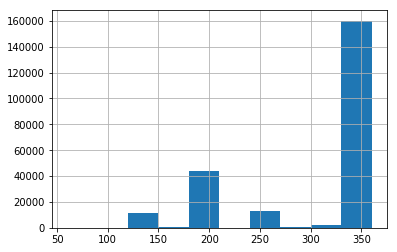

In [642]:
# distribution of loan term
df_s.loan_term.hist();

In [643]:
# max and min loan terms
df_s.loan_term.max()
df_s.loan_term.min()

360

60

Not much difference


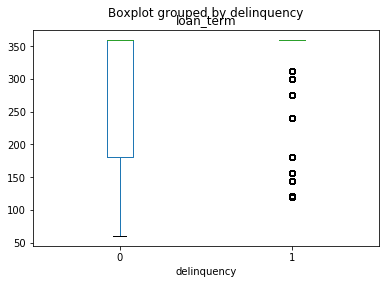

In [644]:
# loan_term vs delinquency
df_s.boxplot(column='loan_term',by='delinquency',grid=False)
print('\33[1mNot much difference');

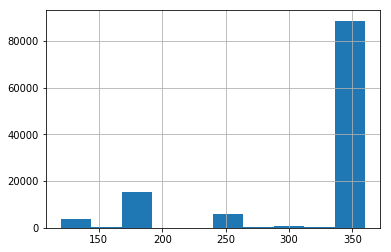

In [645]:
# see the distribution of loan term for delinquency=1
df_s[df_s.delinquency==1].loan_term.hist()

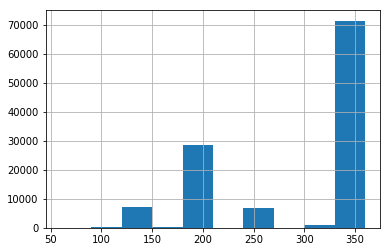

In [646]:
# see the distribution of loan term for delinquency=1
df_s[df_s.delinquency==0].loan_term.hist();

## origination_date

In [647]:
# convert origination date to datetime
df_s.origination_date=pd.to_datetime(df_s.origination_date)
df_s.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency
0,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,04/2012,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [648]:
# Extract month of origination date
df_s['origination_month']=df_s.origination_date.dt.month
df_s.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency,origination_month
0,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,04/2012,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [649]:
# Origination month vs delinquency
df_s.groupby('origination_month')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\33[1mOrigination month and delinquency are negatively correlated')

origination_month
1    0.529
2    0.495
3    0.396
Name: delinquency, dtype: float64

Origination month and delinquency are negatively correlated


## first_payment_date

In [650]:
# convert first payment date to datetime
df_s.first_payment_date=pd.to_datetime(df_s.first_payment_date)
df_s.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency,origination_month
0,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,2012-04-01,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [651]:
# Extract month of first payment date
df_s['first_payment_month']=df_s.first_payment_date.dt.month
df_s.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency,origination_month,first_payment_month
0,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,2012-04-01,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4


In [652]:
# first_payment_month vs delinquency
df_s.groupby('first_payment_month')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\33[1mfirst payment month and delinquency are negatively correlated.But origination and first payement date are correlated, so include one of both')

first_payment_month
2    0.678
3    0.530
4    0.493
5    0.396
Name: delinquency, dtype: float64

first payment month and delinquency are negatively correlated.But origination and first payement date are correlated, so include one of both


## loan_to_value

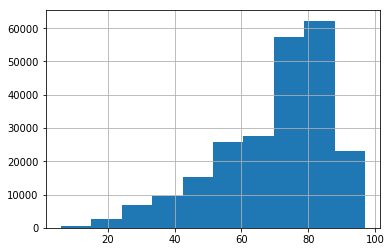

In [653]:
# distribution of loan_to_value
df_s.loan_to_value.hist();

In [654]:
# max and min loan_to_value
df_s.loan_to_value.max()
df_s.loan_to_value.min()

97

6

loan_to_value and delinquency are positively correlated


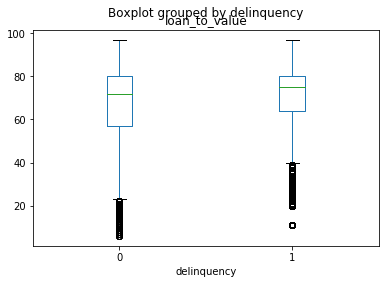

In [655]:
# loan_to_value vs delinquency
df_s.boxplot(column='loan_to_value',by='delinquency',grid=False)
print('\033[1mloan_to_value and delinquency are positively correlated');

## number_of_borrowers

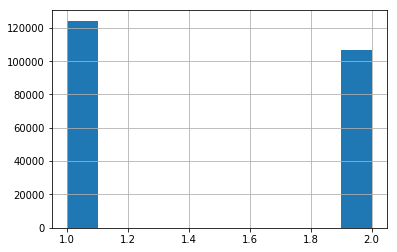

In [656]:
# distribution of number_of_borrowers
df_s.number_of_borrowers.hist();

In [657]:
# first_payment_month vs delinquency
df_s.groupby('number_of_borrowers')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\33[1mnumber_of_borrowers and delinquency are positively correlated.')

number_of_borrowers
1.0    0.624
2.0    0.356
Name: delinquency, dtype: float64

number_of_borrowers and delinquency are positively correlated.


## debt_to_income_ratio

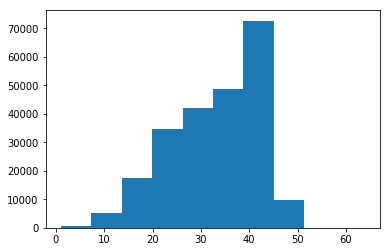

In [658]:
# distribution of debt_to_income_ratio
df_s.debt_to_income_ratio.hist(grid=False);

In [659]:
# max and min debt_to_income_ratio
df_s.debt_to_income_ratio.max()
df_s.debt_to_income_ratio.min()

64.0

1.0

debt_to_income_ratio and delinquency are positively correlated


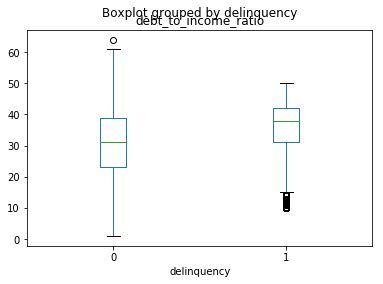

In [660]:
# debt_to_income_ratio vs delinquency
df_s.boxplot(column='debt_to_income_ratio',by='delinquency',grid=False)
print('\033[1mdebt_to_income_ratio and delinquency are positively correlated');

## borrower_credit_score

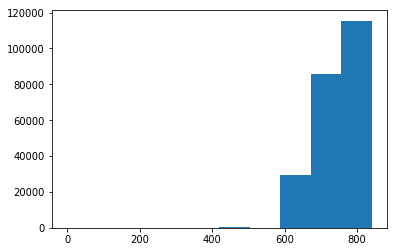

In [661]:
# distribution of borrower_credit_score
df_s.borrower_credit_score.hist(grid=False);

In [662]:
# max and min borrower_credit_score
df_s.borrower_credit_score.max()
df_s.borrower_credit_score.min()

840.0

0.0

borrower_credit_score and delinquency are negatively correlated


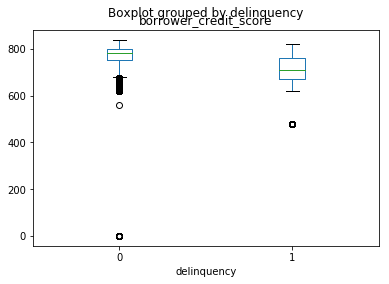

In [663]:
# borrower_credit_score vs delinquency
df_s.boxplot(column='borrower_credit_score',by='delinquency',grid=False)
print('\033[1mborrower_credit_score and delinquency are negatively correlated');

## loan_purpose

In [664]:
# distribution of loan_purpose
round(df_s.loan_purpose.value_counts(normalize=True)*100,2)

A23    41.78
B12    29.95
C86    28.27
Name: loan_purpose, dtype: float64

In [665]:
# loan_purpose vs delinquency
df_s.groupby('loan_purpose')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\033[1mDelinquency is not same across loan purposes')

loan_purpose
A23    0.396
B12    0.578
C86    0.571
Name: delinquency, dtype: float64

Delinquency is not same across loan purposes


## insurance_percent

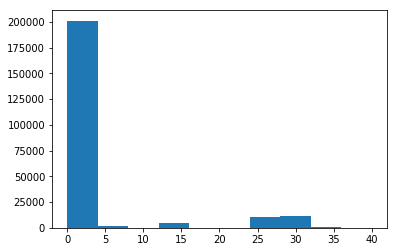

In [666]:
# distribution of insurance_percent
df_s.insurance_percent.hist(grid=False);

insurance_percent and delinquency are negatively correlated


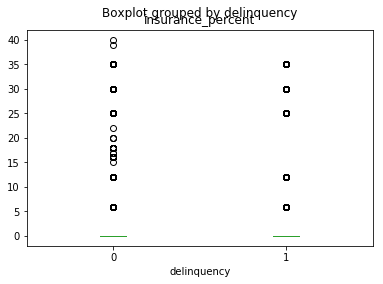

In [667]:
# insurance_percent vs delinquency
df_s.boxplot(column='insurance_percent',by='delinquency',grid=False)
print('\033[1minsurance_percent and delinquency are negatively correlated');

## co-borrower_credit_score

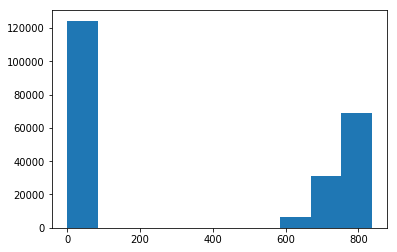

In [668]:
# distribution of co-borrower_credit_score
df_s['co-borrower_credit_score'].hist(grid=False);

co-borrower_credit_score and delinquency are negatively correlated


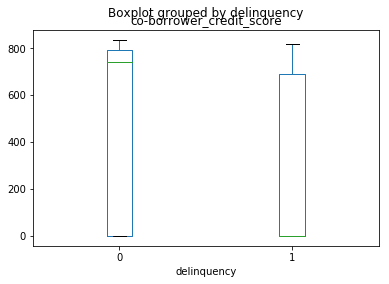

In [669]:
# co-borrower_credit_score vs delinquency
df_s.boxplot(column='co-borrower_credit_score',by='delinquency',grid=False)
print('\033[1mco-borrower_credit_score and delinquency are negatively correlated');

## insurance_type

In [670]:
# distribution of insurance_type
round(df_s.insurance_type.value_counts(normalize=True)*100,2)

0.0    99.45
1.0    0.55 
Name: insurance_type, dtype: float64

In [671]:
# insurance_type vs delinquency
df_s.groupby('insurance_type')['delinquency'].apply(lambda x:round(x.mean(),3))
print('\033[1mDelinquency is not same across insurance types')

insurance_type
0.0    0.499
1.0    0.707
Name: delinquency, dtype: float64

Delinquency is not same across insurance types


# Feature Engineering

In [672]:
# change data types of all categorical variables
categorical_columns=['source','financial_institution','loan_purpose','insurance_type']
for c in categorical_columns:
    df[c]=df[c].astype('category')
df.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency
10851,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,04/2012,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [673]:
# convert origination date to datetime
df.origination_date=pd.to_datetime(df.origination_date)
df.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency
10851,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,04/2012,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [674]:
# convert first payment date to datetime
df.first_payment_date=pd.to_datetime(df.first_payment_date)
df.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,delinquency
10851,Y,Edwards-Hoffman,3.75,345000,240,2012-02-01,2012-04-01,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [675]:
# get difference between origination and first payment date
df['payment_after'] = (df['first_payment_date']-df['origination_date']).dt.days

In [676]:
# drop first payment and origination date
df.drop(columns=['origination_date','first_payment_date'],axis=1,inplace=True)

# Train and Test Split

In [677]:
# subset independent variables
df_X=df[[c for c in df.columns if c not in ['delinquency']]]
df_X.head(1)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,payment_after
10851,Y,Edwards-Hoffman,3.75,345000,240,42,2.0,39.0,806.0,A23,0.0,795.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,60


In [678]:
# subset dependent variable
df_Y=df['delinquency']
df_Y.head(1)

10851    0
Name: delinquency, dtype: int64

In [679]:
# encode categorical variables
one_hot = make_column_transformer((OneHotEncoder(sparse=False),['source', 'financial_institution', 'loan_purpose','insurance_type']),remainder='passthrough')
df_X=one_hot.fit_transform(df_X)

In [683]:
df_X[0]

array([0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
       0.00e+00, 1.00e+00, 0.00e+00, 3.75e+00, 3.45e+05, 2.40e+02,
       4.20e+01, 2.00e+00, 3.90e+01, 8.06e+02, 0.00e+00, 7.95e+02,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       6.00e+01])

In [680]:
# train test split
X_train,X_test,Y_train,Y_test=train_test_split(df_X,df_Y,test_size=0.3,random_state=33)

In [681]:
# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Treat Class Imbalance for Modeling

In [684]:
# some algorithms can't handle imbalanced classes, hence oversample for them
sm=ADASYN(random_state=33)
X_train_s,Y_train_s=sm.fit_resample(X_train,Y_train)

In [685]:
# feature scaling
sc_s = StandardScaler()
X_train_s = sc_s.fit_transform(X_train_s)
X_test_s = sc_s.transform(X_test)

# Modeling

## Logistic Regression

In [686]:
# hyper parameter tuning of logistic regression with randomized search cv
log_model=LogisticRegression(random_state=33,solver='saga',n_jobs=5,multi_class='ovr')
param_grid={'tol':np.arange(0,0.1,0.001),'C':range(1,10),'class_weight':range(1,10,1)}
grid=RandomizedSearchCV(log_model,param_grid,scoring='f1',cv=5,random_state=20)
grid.fit(X_train,Y_train);

In [687]:
# get best score and parameters
grid.best_score_
print(grid.best_params_)

0.4436524057723783

{'tol': 0.01, 'class_weight': 6, 'C': 7}


In [688]:
# take the best model 
log_model=grid.best_estimator_
round(f1_score(Y_train,log_model.predict(X_train)),2)
round(f1_score(Y_test,log_model.predict(X_test)),2)

0.46

0.44

## Neural Networks

In [711]:
# hyper parameter tuning of neural networks with randomized search cv
neu_model=MLPClassifier(learning_rate_init=0.01,learning_rate='adaptive',activation='logistic',random_state=33)
param_grid={'hidden_layer_sizes':[(50),(100,75),(100,75,50)],'alpha':range(1,10,1)}
grid=RandomizedSearchCV(neu_model,param_grid,scoring='f1',cv=5,n_jobs=-1,random_state=33)
grid.fit(X_train_s,Y_train_s);

In [712]:
# get best score and parameters
grid.best_score_
print(grid.best_params_)

0.7611259030932103

{'hidden_layer_sizes': 50, 'alpha': 1}


In [713]:
# take the best model 
neu_model=grid.best_estimator_
round(f1_score(Y_train_s,neu_model.predict(X_train_s)),2)
round(f1_score(Y_test,neu_model.predict(X_test_s)),2)
print('\033[1mOverfitting')

0.79

0.05

Overfitting


## KNN

In [692]:
knn_model=KNeighborsClassifier(n_neighbors=10,weights='distance',algorithm='ball_tree',metric='minkowski',n_jobs=-1)
knn_model.fit(X_train_s,Y_train_s);

In [693]:
round(f1_score(Y_train_s,knn_model.predict(X_train_s)),2)
round(f1_score(Y_test,knn_model.predict(X_test_s)),2)

1.0

0.15

## Decision Tree

In [714]:
# hyper parameter tuning of decision tree with randomized search cv
dec_model=DecisionTreeClassifier(random_state=33)
param_grid=dict(max_depth=range(3,20),min_samples_split=range(50,200,10),min_samples_leaf=range(25,100,10),max_leaf_nodes=range(8,32,2),min_impurity_decrease=(0.3,1.0,0.1))
grid=RandomizedSearchCV(dec_model,param_grid,scoring='',n_jobs=4,cv=5)
grid.fit(X_train,Y_train);

In [715]:
# get best score and parameters
grid.best_score_
grid.best_params_

0.0

{'min_samples_split': 180,
 'min_samples_leaf': 25,
 'min_impurity_decrease': 0.3,
 'max_leaf_nodes': 14,
 'max_depth': 6}

In [716]:
# take the best model 
dec_model=grid.best_estimator_
round(f1_score(Y_train,dec_model.predict(X_train),labels=np.unique(dec_model.predict(X_train))),2)
round(f1_score(Y_test,dec_model.predict(X_test),labels=np.unique(dec_model.predict(X_test))),2)
print('\033[1mOverfitting')

0.0

0.0

Overfitting


## Random Forest

In [698]:
# hyper parameter tuning of random forest with randomized search cv
rf_model=RandomForestClassifier(random_state=33)
param_grid=dict(n_estimators=range(10,100,10),max_depth=range(3,20),min_samples_split=range(50,200,20),min_samples_leaf=range(25,75,10),max_leaf_nodes=range(8,32,2))
grid=RandomizedSearchCV(rf_model,param_grid,scoring='f1',n_jobs=-1,cv=5,random_state=33)
grid.fit(X_train,Y_train);

In [699]:
# get best score and parameters
grid.best_score_
print(grid.best_params_)

0.3959893829272206

{'n_estimators': 20, 'min_samples_split': 50, 'min_samples_leaf': 35, 'max_leaf_nodes': 12, 'max_depth': 18}


In [700]:
# take the best model 
rf_model=grid.best_estimator_
round(f1_score(Y_train,rf_model.predict(X_train)),2)
round(f1_score(Y_test,rf_model.predict(X_test)),2)

0.4

0.38

## Adaboost

In [701]:
# hyper parameter tuning of ada boost with randomized search cv
param_grid={'learning_rate':np.arange(0.01,0.3,0.01)}
ada_model=AdaBoostClassifier(n_estimators=100,random_state=33)
grid=RandomizedSearchCV(ada_model,param_grid,scoring='f1',n_jobs=-1,cv=5,random_state=33)
grid.fit(X_train,Y_train);

In [702]:
# get best score and parameters
grid.best_score_
print(grid.best_params_)

0.47831407567987483

{'learning_rate': 0.24000000000000002}


In [703]:
# take the best model 
ada_model=grid.best_estimator_
round(f1_score(Y_train,ada_model.predict(X_train)),2)
round(f1_score(Y_test,ada_model.predict(X_test)),2)

0.48

0.46

## XGBoost

In [704]:
# hyper parameter tuning of xgboost with randomized search cv
xgb_model=XGBClassifier(n_jobs=-1)
param_grid={'max_depth':range(5,15,3),'learning_rate':np.arange(0.01,0.3,0.01),'n_estimators':range(100,200,10),'min_child_weight':range(1,15,2),'reg_lambda':range(0,5,1),'subsample':np.arange(60,110,10)/100,'colsample_bylevel':np.arange(60,110,10)/100,'colsample_bytree':np.arange(60,110,10)/100,'colsample_bynode':np.arange(60,110,10)/100,'scale_pos_weight':np.arange(1,15,1)}
grid=RandomizedSearchCV(xgb_model,param_grid,scoring='f1',n_jobs=-1,cv=5,random_state=33)
grid.fit(X_train,Y_train);

In [705]:
# get best score and parameters
grid.best_score_
print(grid.best_params_)

0.5259956581823991

{'subsample': 0.9, 'scale_pos_weight': 3, 'reg_lambda': 1, 'n_estimators': 130, 'min_child_weight': 13, 'max_depth': 8, 'learning_rate': 0.02, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.8}


In [706]:
# take the best model 
xgb_model=grid.best_estimator_
round(f1_score(Y_train,xgb_model.predict(X_train)),2)
round(f1_score(Y_test,xgb_model.predict(X_test)),2)

0.58

0.53

<Figure size 36000x36000 with 0 Axes>

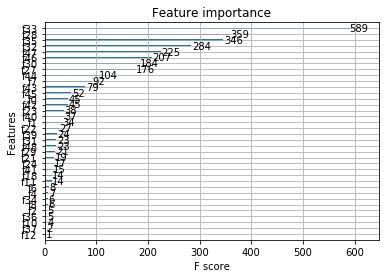

In [707]:
plt.figure(figsize=(500, 500))
plot_importance(xgb_model)
plt.show();

## Submission

In [751]:
# load test data
test=pd.read_csv('Data/test.csv')
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [752]:
# convert origination date to datetime
test.origination_date=pd.to_datetime(test.origination_date)
test.head(1)

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,2012-01-02,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [753]:
# convert first payment date to datetime
test.first_payment_date=pd.to_datetime(test.first_payment_date,format='%b-%y')
test.head(1)

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,2012-01-02,2012-04-01,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [754]:
# get difference between origination and first payment date
test['payment_after'] = (test['first_payment_date']-test['origination_date']).dt.days

In [755]:
# drop loan_id,first payment and origination date
test.drop(columns=['origination_date','first_payment_date'],axis=1,inplace=True)

In [757]:
# one hot encode categorical variables
test_X=one_hot.transform(test.drop(columns=['loan_id'],axis=1))

In [758]:
# feature scaling
test_X=sc.transform(test_X)

In [761]:
# predict with XGBoost
final_submission=pd.DataFrame({'loan_id':test.loan_id,'m13':xgb_model.predict(test_X)})
final_submission.head()

,loan_id,m13
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [762]:
# check the distribution of predictions
final_submission.m13.value_counts()

0    35738
1    128  
Name: m13, dtype: int64

In [763]:
final_submission.to_csv('final_submission.csv',header=True,index=None)